I found that the greater the difference in style between the content image and the style image, the more pronounced the effect of style transfer.

# 1.Set environment

## Based on notebook : 
https://www.tensorflow.org/tutorials/generative/style_transfer#define_content_and_style_representations

In [39]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
from keras import backend as K
#from keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.utils import load_img, save_img, img_to_array
from keras.applications import vgg19
from keras.models import Model
#from keras import optimizers
from scipy.optimize import fmin_l_bfgs_b
#from keras.applications.vgg19 import VGG19
#vgg19_weights = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
#vgg19 = VGG19(include_top = False, weights=vgg19_weights)
print(os.listdir("best-artworks-of-all-time"))


# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

['artists.csv', 'images', 'resized']


In [40]:
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [41]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

# 2.Load dataset

In [42]:
files = os.listdir('best-artworks-of-all-time')

In [43]:
ContentPath = 'best-artworks-of-all-time/images/images/Caravaggio'
StylePath = 'best-artworks-of-all-time/images/images'

In [44]:
content_path = ContentPath + '/Caravaggio_54.jpg'
style_path1 = StylePath + '/Andy_Warhol/Andy_Warhol_27.jpg'
style_path2 = StylePath + '/Paul_Gauguin/Paul_Gauguin_19.jpg'

### 2.1 load image to check

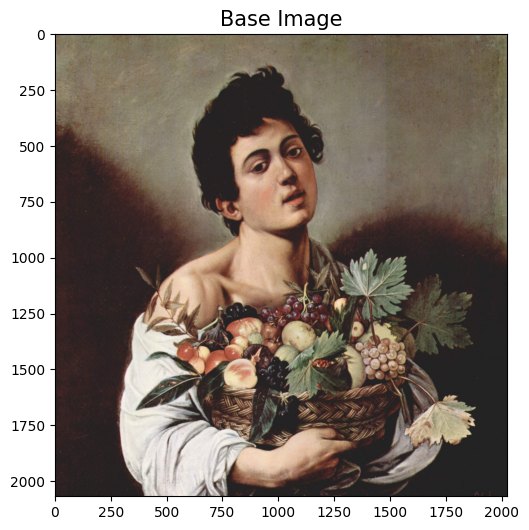

In [45]:
plt.figure()
plt.title("Base Image",fontsize=15)
img1 = load_img(content_path)
plt.imshow(img1)

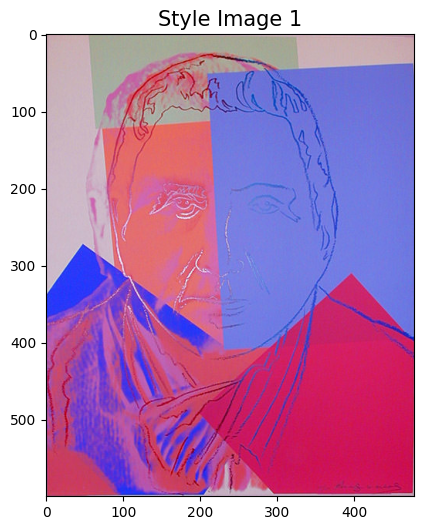

In [8]:
plt.figure()
plt.title("Style Image 1",fontsize=15)
img1 = load_img(style_path1)
plt.imshow(img1)

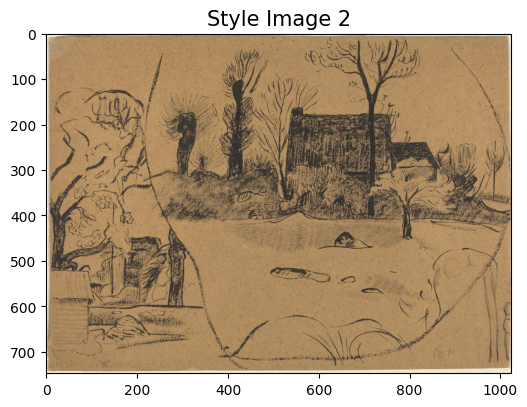

In [48]:
plt.figure()
plt.title("Style Image 2",fontsize=15)
img1 = load_img(style_path2)
plt.imshow(img1)

### 2.2 resize and group content image and style image

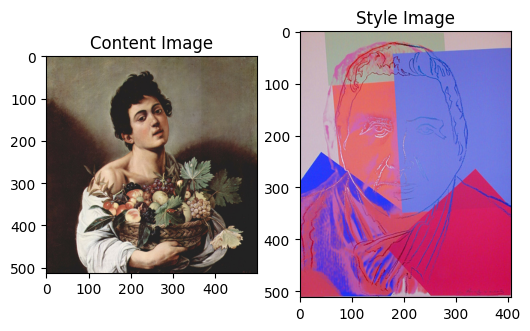

In [51]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

content_image = load_img(content_path)
style_image1 = load_img(style_path1)
style_image2 = load_img(style_path2)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image1, 'Style Image')

# Method 1: Using Tenserflow hub to transform style

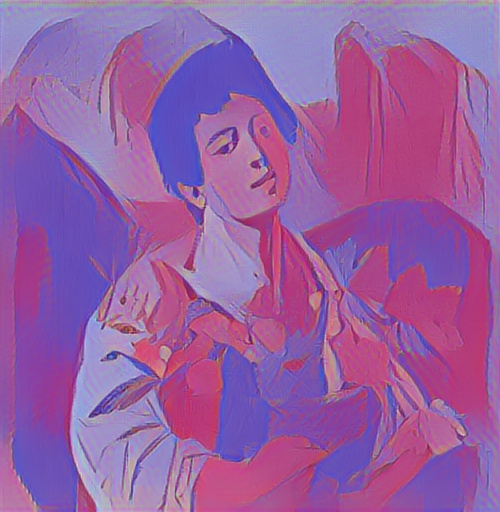

In [10]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image1 = hub_model(tf.constant(content_image), tf.constant(style_image1))[0]
tensor_to_image(stylized_image1)


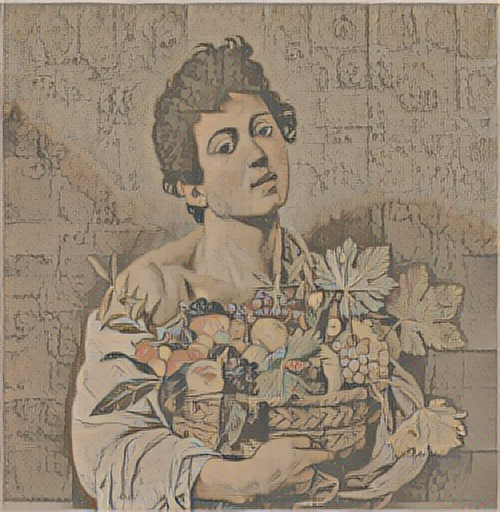

In [52]:
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image2 = hub_model(tf.constant(content_image), tf.constant(style_image2))[0]
tensor_to_image(stylized_image2)

# Method 2: fine tuning VGG

In [11]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [12]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('groom', 0.21419215),
 ('gown', 0.17578685),
 ('hoopskirt', 0.07325504),
 ('overskirt', 0.07199384),
 ('kimono', 0.063228704)]

In [13]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
#vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
print()
for layer in vgg.layers:
  print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [14]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

#num_content_layers = len(content_layers)
#num_style_layers = len(style_layers)

num_content_layers = 30
num_style_layers = 30

### 2.1 Build model

In [15]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [16]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image1*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 512, 407, 64)
  min:  0.0
  max:  686.1757
  mean:  39.814114

block2_conv1
  shape:  (1, 256, 203, 128)
  min:  0.0
  max:  4015.393
  mean:  177.494

block3_conv1
  shape:  (1, 128, 101, 256)
  min:  0.0
  max:  8585.555
  mean:  158.35522

block4_conv1
  shape:  (1, 64, 50, 512)
  min:  0.0
  max:  19095.252
  mean:  588.84955

block5_conv1
  shape:  (1, 32, 25, 512)
  min:  0.0
  max:  2271.5889
  mean:  38.768166



### 2.2 Calculate style

In [17]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [18]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [19]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.067333534
    max:  15896.411
    mean:  309.62665

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  66763.93
    mean:  11305.283

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  215129.25
    mean:  10505.614

   block4_conv1
    shape:  (1, 512, 512)
    min:  40.33396
    max:  3070198.8
    mean:  164770.64

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  55732.09
    mean:  1414.655

Contents:
   block5_conv2
    shape:  (1, 32, 31, 512)
    min:  0.0
    max:  1199.9492
    mean:  13.380787


### Gradient descent

In [20]:
style_targets = extractor(style_image1)['style']
content_targets = extractor(content_image)['content']

In [21]:
image = tf.Variable(content_image)

In [22]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [23]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [24]:
style_weight=1e-2
content_weight=1e4

In [25]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [26]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

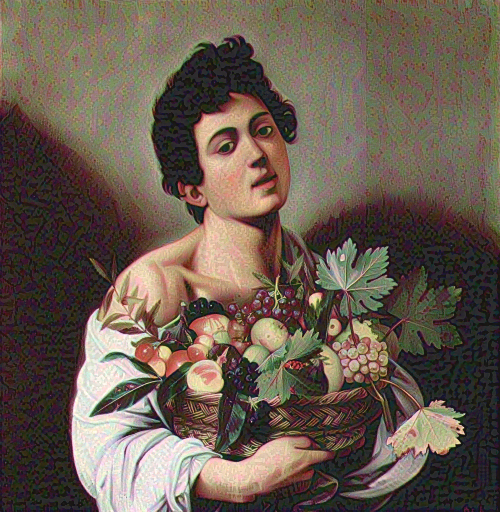

In [27]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

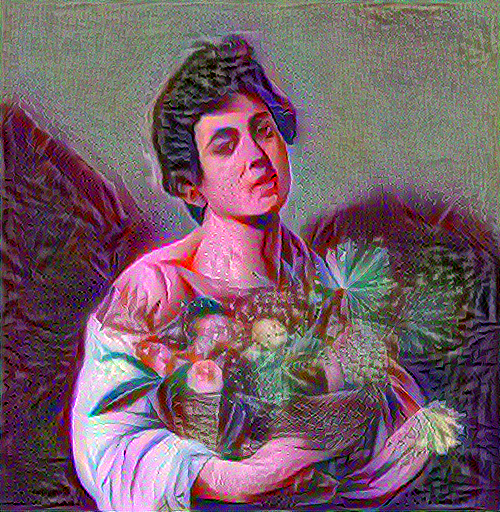

Train step: 100
Total time: 177.7


In [28]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 10

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

# Optimization
These code from: 
https://www.tensorflow.org/tutorials/generative/style_transfer#define_content_and_style_representations

In [33]:
total_variation_weight=50

In [34]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [35]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

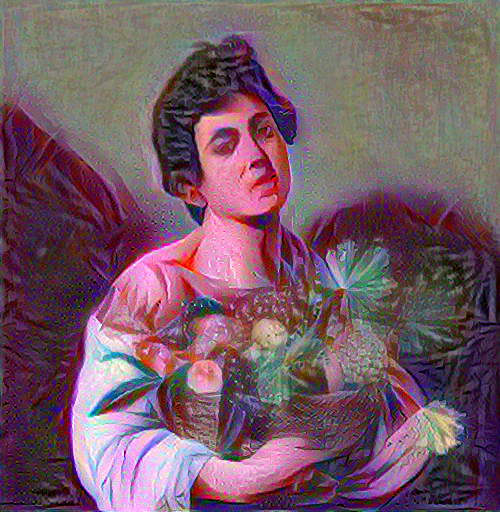

Train step: 100
Total time: 176.9


In [32]:
# this picture is get when total_variation_weight =30. which is the number suggested by code source. I changed it into 50 in the next try
#This is because I want to see how the value of total_variation_weight can affect the optimizor
import time
start = time.time()

epochs = 10
steps_per_epoch = 10

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))


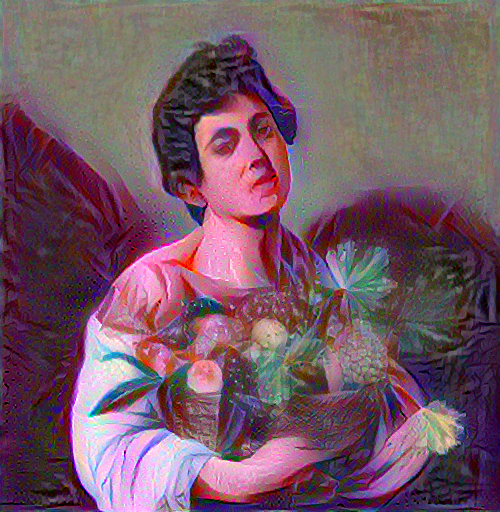

Train step: 100
Total time: 176.8


In [36]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 10

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

# VGG model with different weight and layers

In [53]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
#vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
print()
for layer in vgg.layers:
  print(layer.name)

content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

#num_content_layers = len(content_layers)
#num_style_layers = len(style_layers)

num_content_layers = 50
num_style_layers = 50


def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image1*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()
    
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())




input_10
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
block1_conv1
  shape:  (1, 512, 407, 64)
  min:  0.0
  max:  686.1757
  mean:  39.814114

block2_conv1
  shape:  (1, 256, 203, 128)
  min:  0.0
  max:  4015.393
  mean:  177.494

block3_conv1
  shape:  (1, 128, 101, 256)
  min:  0.0
  max:  8585.555
  mean:  158.35522

block4_conv1
  shape:  (1, 64, 50, 512)
  min:  0.0
  max:  19095.252
  mean:  588.84955

block5_conv1
  shape:  (1, 32, 25, 512)
  min:  0.0
  max:  2271.5889
  mean:  38.768166

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.067333534
    max:  15896.411
    mean:  309.62665

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  66763.93
    mean:  11305.283

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max

In [56]:
style_targets = extractor(style_image2)['style']
content_targets = extractor(content_image)['content']

In [57]:
image = tf.Variable(content_image)

In [58]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [59]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [60]:
style_weight=0.05
content_weight=0.02

In [61]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [62]:
total_variation_weight=50

In [63]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))




In [64]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

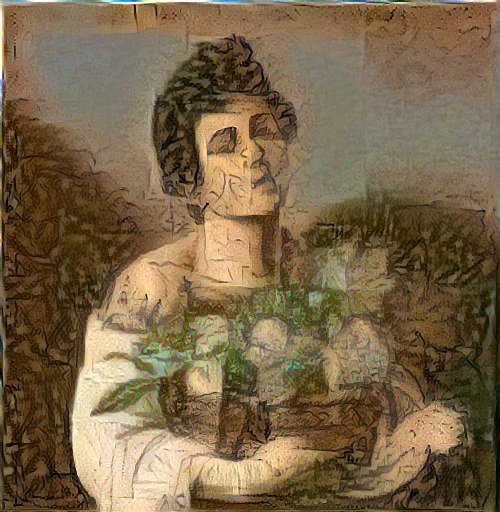

Train step: 100
Total time: 178.8


In [65]:
# this picture is get when total_variation_weight =30. which is the number suggested by code source. I changed it into 50 in the next try
#This is because I want to see how the value of total_variation_weight can affect the optimizor
import time
start = time.time()

epochs = 10
steps_per_epoch = 10

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

# Save

In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)